In [43]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import pandas_datareader as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Preparation

### Download Carhart's factors

In [196]:
threeFactor = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='2000-01-01').read()[0]/100
momFactor = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='2000-01-01').read()[0]/100
fourFactor = pd.concat([threeFactor,momFactor],axis=1)

### Import the evaluator

In [188]:
class Evaluator():
  def __init__(self,name,returns,fourFactor):
    self.name = name
    self.set_returns(returns)
    self.set_fourFactor(fourFactor)
  def set_fourFactor(self,fourFactor):
    self.fourFactor = fourFactor.copy()
    self.fourFactor['Ret-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    summary = pd.DataFrame()
    summary.loc['Cum Return',['Value','Sample size']] = self.get_cumRet()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Ret-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Ret-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.fourFactor['Ret-RF'].mean()*252/self.get_vol()[0]
    sampleSize = self.returns.size
    return sharpeRatio,sampleSize
  def get_monthlyReturns(self):
    monthlyReturns = self.returns.resample('M').sum()
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod/cumprod.expanding().max() - 1
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

## Construct the portfolio

### Read earnings data

In [116]:
ryan = pd.read_excel('earnings.xlsx','Ryan New')
markus = pd.read_excel('earnings.xlsx','Markus New')
ben = pd.read_excel('earnings.xlsx','Ben')

In [130]:
combined = pd.concat([ryan,markus,ben])
#combined.dropna(inplace=True)

In [131]:
def toDate(cell):
    try:
        cell = datetime.datetime.strptime(cell[:-3],'%b %d, %Y, %I %p')
    except:
        cell = datetime.datetime.strptime(cell[:-3],'%b %d, %Y at %I %p')
    return cell
combined['Announcement Date'] = combined['Announcement Date'].map(toDate)

In [175]:
combined['Date'] = combined['Announcement Date']
def toNextDay(cell):
    if cell.time() >= datetime.time(16,00,00):
        cell = cell.date() + datetime.timedelta(1)
    else:
        cell = cell.date()
    #row['Date'] = row['Date'] + datetime.timedelta(1)
    return cell
combined['Date'] = combined['Date'].map(toNextDay)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\367605206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['Date'] = combined['Announcement Date']
C:\Users\benka\AppData\Local\Temp\ipykernel_11732\367605206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['Date'] = combined['Date'].map(toNextDay)


In [146]:
combined[combined=='-'] = np.nan
combined.dropna(inplace=True)

In [177]:
def getZ(group):
    group = group.sort_values('Announcement Date')
    group['Surprise Z'] = (group['Surprise %'])/group['Surprise %'].rolling(8).std()
    #print(group)
    return group
combined = combined.groupby('Company Code').apply(getZ).reset_index(drop=True)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3907684453.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  combined = combined.groupby('Company Code').apply(getZ).reset_index(drop=True)


In [178]:
combined = combined[combined['Surprise Z'].notna()]

In [179]:
symbols = combined['Company Code'].unique().tolist()
price = yf.download(symbols)

[*********************100%***********************]  101 of 101 completed


In [180]:
logReturn = np.log(price['Adj Close']).diff()
pctReturn = price['Adj Close'].pct_change()
firstDayReturn = (price['Open']-price['Close'].shift(1))/price['Close'].shift(1)

In [181]:
returns = pd.DataFrame()

## Long-short (1 week holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3365606608.py:12: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

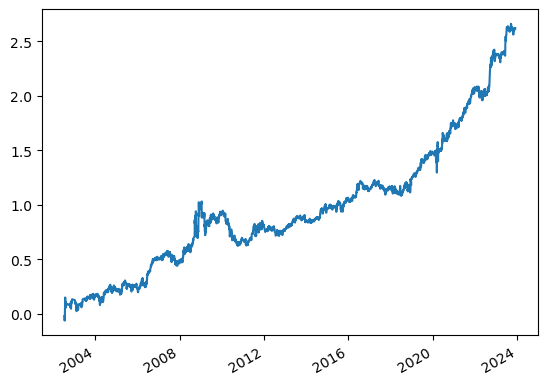

In [209]:
combined['Long Position'] = np.where(combined['Surprise Z']>0,1,0)
combined['Short Position'] = np.where(combined['Surprise Z']<0,-1,0)
combined['Position'] = combined['Long Position'] + combined['Short Position']
def getPosition(group,duration=5):
    try:
        dateRange = pd.date_range('1800-01-01','1800-01-01')
        for date in group['Date']:
            startDate = date
            endDate = date + datetime.timedelta(duration)
            dateRange = dateRange.union(pd.date_range(startDate,periods=duration,freq='B'))
        group = group.set_index('Date')['Position']
        position = group.reindex(dateRange[1:]).ffill()
        return position
    except:
        return

positions = combined.groupby('Company Code').apply(getPosition,6).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack()
positions.index.name = None
positions.columns.name = None
positions = positions['Position']
max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L/S 1w'] = ((pctReturn.shift(-2)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L/S 1w'].cumsum().plot()

In [206]:
evaluator = Evaluator('long-short 1w',returns['L/S 1w'],fourFactor)
evaluator.get_summary()

Value  Sample size   P-value
Cum Return          7.539880          1.0       NaN
Mean                0.135401       4545.0       NaN
Vol                 0.181889       4545.0       NaN
SR                  0.698428       4545.0       NaN
CAPM Alpha          0.128390       4365.0  0.003934
Carhart Alpha       0.128409       4365.0  0.003946
Skew                0.716182       4545.0       NaN
Kurt               14.622104       4545.0       NaN
Avg Drawdown       -0.061385       4204.0       NaN
Max Drawdown       -0.257559          1.0       NaN
Downside Risk       0.008582       2286.0       NaN
VaR 95%            -0.016833       4545.0       NaN
Exp Shortfall 95%  -0.025722        228.0       NaN
VaR 99%            -0.031492       4545.0       NaN
Exp Shortfall 99%  -0.041358         46.0       NaN

In [190]:
evaluator.get_CAPMSummary()

AttributeError: 'Evaluator' object has no attribute 'get_CAPMSummary'

## Long-short (1 month holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3418788263.py:10: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

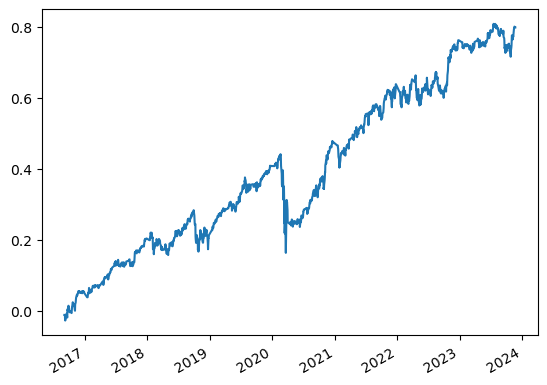

In [58]:
combined['Position'] = np.where(combined['Surprise Z']>0,1,-1)
positions = combined.groupby('Company Code').apply(getPosition,30).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack().iloc[1:]
positions.index.name = None
positions.columns.name = None
positions = positions['Position']
max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L/S 1m'] = ((pctReturn.shift(-1)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L/S 1m'].cumsum().plot()

In [59]:
Evaluator('long-short 1m',returns['L/S 1m'],fourFactor).get_summary()

Value  Sample size   P-value
Cum Return          1.219882       1587.0       NaN
Mean                0.126708       1587.0       NaN
Vol                 0.136248       1587.0       NaN
SR                  0.814239       1587.0       NaN
CAPM Alpha          0.122836       1502.0  0.028463
Carhart Alpha       0.124352       1502.0  0.025756
Skew (M)           -0.716682         87.0       NaN
Kurt               22.301081       1587.0       NaN
Avg Drawdown       -0.057304       1342.0       NaN
Max Drawdown       -0.376621          1.0       NaN
Downside Risk       0.006089        854.0       NaN
VaR 95%            -0.011362       1587.0       NaN
Exp Shortfall 95%  -0.020357         80.0       NaN
VaR 99%            -0.023121       1587.0       NaN
Exp Shortfall 99%  -0.036641         16.0       NaN

## Long only (1 week holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\63791395.py:12: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

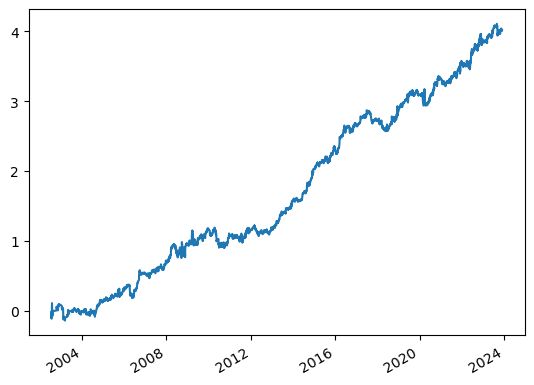

In [193]:
combined['Long Position'] = np.where(combined['Surprise Z']>0,1,0)
combined['Short Position'] = np.where(combined['Surprise Z']<0,-1,0)
combined['Position'] = combined['Long Position']# + combined['Short Position']
positions = combined.groupby('Company Code').apply(getPosition,6).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack()
positions.index.name = None
positions.columns.name = None
positions = positions['Position']
max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L 1w'] = ((pctReturn.shift(-1)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L 1w'].cumsum().plot()

In [194]:
Evaluator('long only 1w',returns['L 1w'],fourFactor).get_summary()

Value  Sample size   P-value
Cum Return         32.946817          1.0       NaN
Mean                0.222152       4545.0       NaN
Vol                 0.230797       4545.0       NaN
SR                  1.064818       4545.0       NaN
CAPM Alpha          0.254480       1926.0  0.002220
Carhart Alpha       0.253527       1926.0  0.002319
Skew                0.039182       4545.0       NaN
Kurt               14.206641       4545.0       NaN
Avg Drawdown       -0.076952       4147.0       NaN
Max Drawdown       -0.266867          1.0       NaN
Downside Risk       0.010808       2300.0       NaN
VaR 95%            -0.019205       4545.0       NaN
Exp Shortfall 95%  -0.033189        228.0       NaN
VaR 99%            -0.038995       4545.0       NaN
Exp Shortfall 99%  -0.060218         46.0       NaN

## Long only (1 month holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3418788263.py:10: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

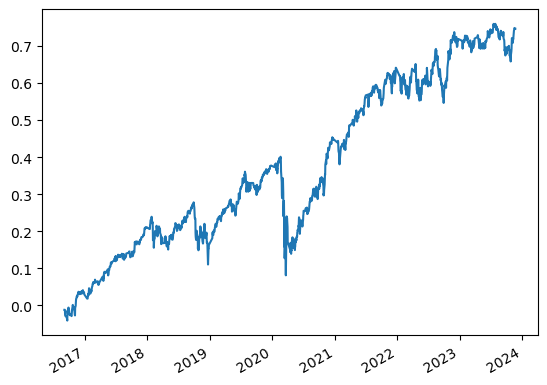

In [62]:
combined['Position'] = np.where(combined['Surprise Z']>0,1,0)
positions = combined.groupby('Company Code').apply(getPosition,30).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack().iloc[1:]
positions.index.name = None
positions.columns.name = None
positions = positions['Position']
max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L 1m'] = ((pctReturn.shift(-1)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L 1m'].cumsum().plot()

In [63]:
Evaluator('long only 1m',returns['L 1m'],fourFactor).get_summary()

Value  Sample size   P-value
Cum Return          1.108053       1587.0       NaN
Mean                0.118495       1587.0       NaN
Vol                 0.162295       1587.0       NaN
SR                  0.629642       1587.0       NaN
CAPM Alpha          0.116303       1502.0  0.082327
Carhart Alpha       0.118745       1502.0  0.074057
Skew (M)           -0.593924         87.0       NaN
Kurt               19.952874       1587.0       NaN
Avg Drawdown       -0.067197       1380.0       NaN
Max Drawdown       -0.408378          1.0       NaN
Downside Risk       0.007141        849.0       NaN
VaR 95%            -0.013945       1587.0       NaN
Exp Shortfall 95%  -0.024388         80.0       NaN
VaR 99%            -0.027804       1587.0       NaN
Exp Shortfall 99%  -0.044671         16.0       NaN

## Long only + 1SD filter (1 week holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3418788263.py:10: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

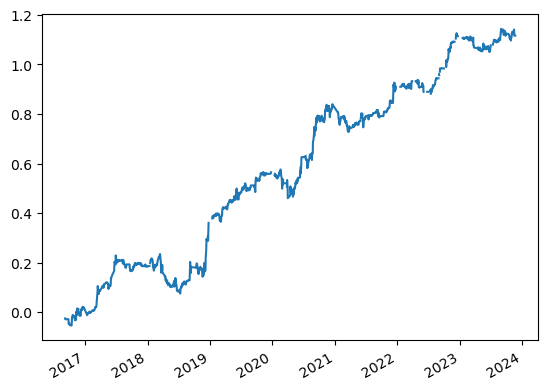

In [64]:
combined['Position'] = np.where(combined['Surprise Z']>1,1,0)
positions = combined.groupby('Company Code').apply(getPosition,7).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack().iloc[1:]
positions.index.name = None
positions.columns.name = None
positions = positions['Position']

emac = price['Adj Close'] - price['Adj Close'].ewm(250).mean()
positions = positions[emac>0]


max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L+1SD 1w'] = ((pctReturn.shift(-1)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L+1SD 1w'].cumsum().plot()

In [65]:
Evaluator('long with trend filer 1w',returns['L+1SD 1w'],fourFactor).get_summary()

Value  Sample size   P-value
Cum Return               NaN       1587.0       NaN
Mean                0.188408       1587.0       NaN
Vol                 0.139078       1587.0       NaN
SR                  1.289260       1587.0       NaN
CAPM Alpha          0.186239       1462.0  0.001310
Carhart Alpha       0.185122       1462.0  0.001409
Skew (M)            1.090338         87.0       NaN
Kurt               12.323293       1587.0       NaN
Avg Drawdown       -0.067593       1322.0       NaN
Max Drawdown       -0.243140          1.0       NaN
Downside Risk       0.006940        713.0       NaN
VaR 95%            -0.011688       1587.0       NaN
Exp Shortfall 95%  -0.019394         75.0       NaN
VaR 99%            -0.023717       1587.0       NaN
Exp Shortfall 99%  -0.031515         15.0       NaN

## Long only + 1SD filter (1 month holding period)

C:\Users\benka\AppData\Local\Temp\ipykernel_11732\3418788263.py:10: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  position = group.reindex(dateRange[1:]).ffill()


<Axes: >

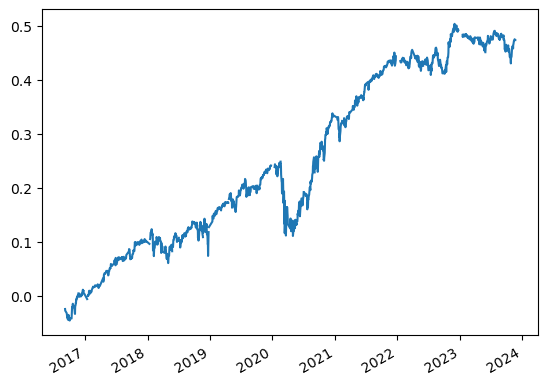

In [66]:
combined['Position'] = np.where(combined['Surprise Z']>1,1,0)
positions = combined.groupby('Company Code').apply(getPosition,30).reset_index()
positions.columns = ['Company Code','Date','Position']
positions = positions.set_index(['Date','Company Code']).unstack().iloc[1:]
positions.index.name = None
positions.columns.name = None
positions = positions['Position']

emac = price['Adj Close'] - price['Adj Close'].ewm(250).mean()
positions = positions[emac>0]


max_positions = positions.sum(axis=1).max()
idx = positions[positions.notna().any(axis=1)].index
returns['L+1SD 1m'] = ((pctReturn.shift(-1)*positions).mean(axis=1)).loc[idx].fillna(0)
returns['L+1SD 1m'].cumsum().plot()

In [67]:
Evaluator('long with trend filer 1m',returns['L+1SD 1m'],fourFactor).get_summary()

Value  Sample size   P-value
Cum Return               NaN       1587.0       NaN
Mean                0.077714       1587.0       NaN
Vol                 0.093620       1587.0       NaN
SR                  0.678110       1587.0       NaN
CAPM Alpha          0.073502       1502.0  0.051275
Carhart Alpha       0.074837       1502.0  0.045462
Skew (M)           -0.180428         87.0       NaN
Kurt               15.382199       1587.0       NaN
Avg Drawdown       -0.029537       1317.0       NaN
Max Drawdown       -0.164917          1.0       NaN
Downside Risk       0.004166        845.0       NaN
VaR 95%            -0.009119       1587.0       NaN
Exp Shortfall 95%  -0.014333         77.0       NaN
VaR 99%            -0.016313       1587.0       NaN
Exp Shortfall 99%  -0.024234         16.0       NaN

<Axes: title={'center': 'Log return'}>

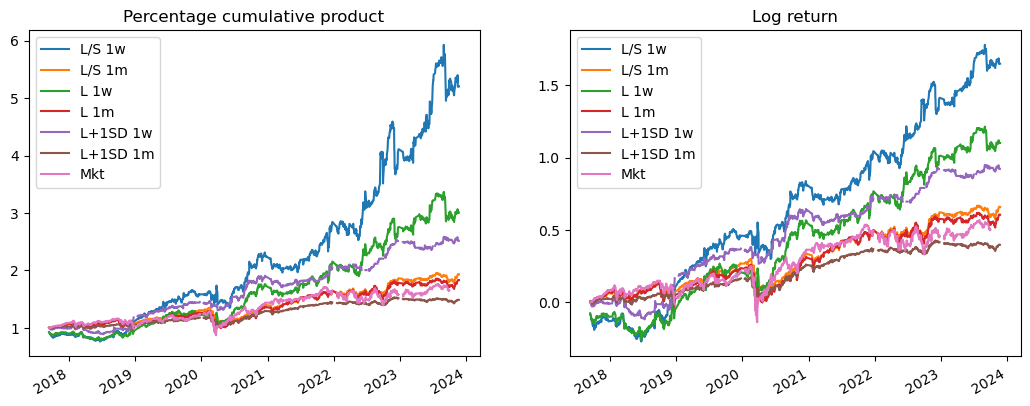

In [68]:
fig,axes = plt.subplots(1,2,figsize=(6.4*2,4.8))
returns['Mkt'] = fourFactor['Mkt-RF']+fourFactor['RF']
returns = returns[returns.index>'2017-09-01']
np.exp(returns.cumsum()).plot(ax=axes[0],title='Percentage cumulative product')
returns.cumsum().plot(ax=axes[1],title='Log return')

<Axes: >

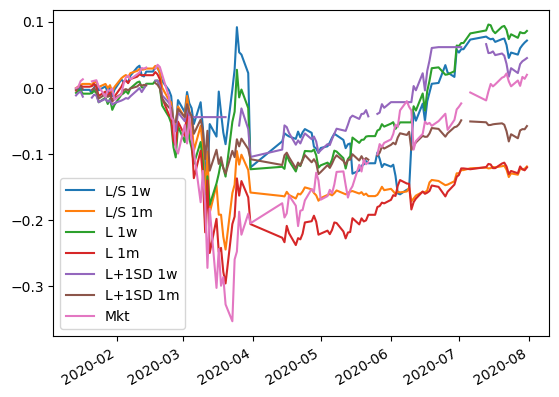

In [69]:
returns['2020':'2020-07'].cumsum().plot()

## Test for forward looking bias

In [207]:
eqPort = logReturn.mean(axis=1)

df = fourFactor.copy()
df['eqPort'] = eqPort-df['RF']
df['strat'] = returns['L/S 1w']-df['RF']
df = df.dropna()

Y = df['strat']
X = sm.add_constant(df[['Mkt-RF','SMB','HML','Mom   ','eqPort']])

model = sm.OLS(Y,X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  strat   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5401
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.746
Time:                        00:30:33   Log-Likelihood:                 13238.
No. Observations:                4365   AIC:                        -2.646e+04
Df Residuals:                    4359   BIC:                        -2.643e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.887      0.004       0.000       0.001
Mkt-RF         0.0355      0.092      0.385      0.700      -0.145       0.216
SMB           -0.0274      0.030     -0.911      0.362      -0.086       0.032
HML           -0.0139      0.027     -0.509      0.611      -0.067       0.040
Mom           -0.0119      0.019     -0.621      0.534      -0.049       0.026
eqPort        -0.0502      0.093     -0.539      0.590      -0.233       0.132
==============================================================================
Omnibus:                     1190.981   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35120.422
Skew:                           0.678   Prob(JB):                         0.00
Kurtosis:                      16.830   Cond. No.                         744.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
df.corr()

Mkt-RF       SMB       HML        RF    Mom       eqPort     strat
Mkt-RF  1.000000  0.154404  0.164579 -0.016694 -0.272658  0.983359 -0.000935
SMB     0.154404  1.000000 -0.069727 -0.026414 -0.026028  0.103025 -0.036885
HML     0.164579 -0.069727  1.000000 -0.008444 -0.421379  0.252656  0.006112
RF     -0.016694 -0.026414 -0.008444  1.000000  0.011666 -0.014187 -0.003629
Mom    -0.272658 -0.026028 -0.421379  0.011666  1.000000 -0.323305 -0.008931
eqPort  0.983359  0.103025  0.252656 -0.014187 -0.323305  1.000000  0.001753
strat  -0.000935 -0.036885  0.006112 -0.003629 -0.008931  0.001753  1.000000

<Axes: xlabel='Date'>

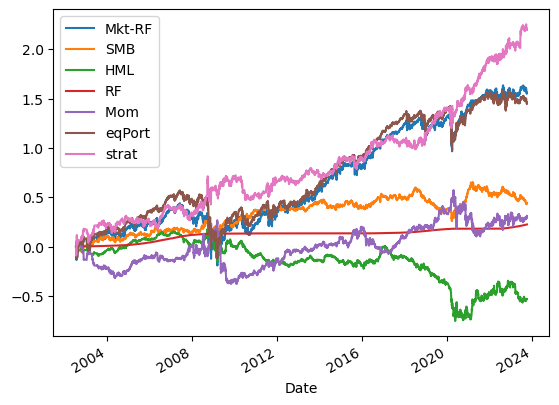

In [210]:
df.cumsum().plot()

## Check alpha

<Axes: xlabel='Date'>

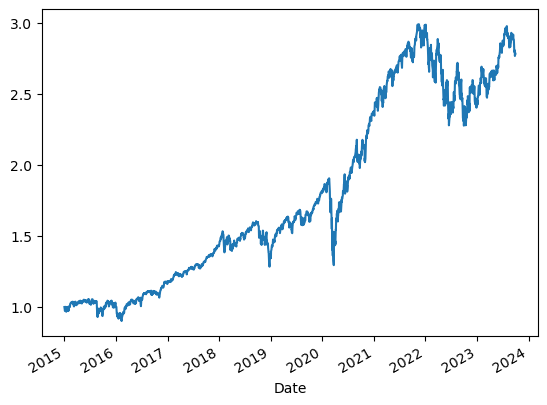

In [73]:
np.exp((fourFactor['Mkt-RF']+fourFactor['RF']).cumsum()).plot()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

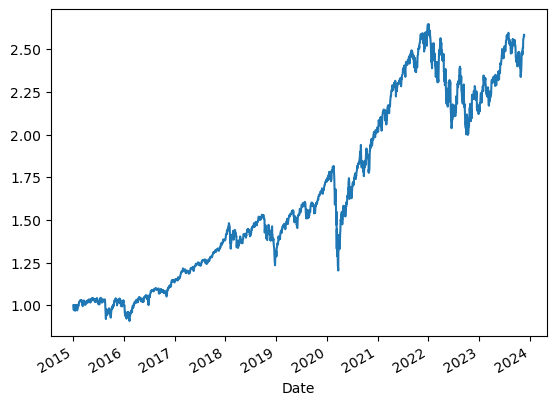

In [74]:
mkt = yf.download('SPY')['Adj Close']
(1+mkt.pct_change())['2015-01-01':].cumprod().plot()